In [1]:
import numpy as np 
import matplotlib. pyplot as plt
import functions

In [2]:
label_names = ['no', 'yes', 'on', 'off', 'down', 'up', 'left', 'right', 'go', 'wow']

data = np.load('voice_spectrograms.npz')

X_train_std, y_train_num, X_test_std, y_test_num = [data[f] for f in data.files]

In [3]:
print(X_test_std.shape)

(2000, 129, 71)


In [4]:
print(X_train_std.shape)
X_train_std = np.reshape(X_train_std, (-1, 129, 71))
X_test_std = np.reshape(X_test_std, (-1, 129, 71))
print(X_test_std.shape)

(15000, 129, 71)
(2000, 129, 71)


(2000, 70, 70)


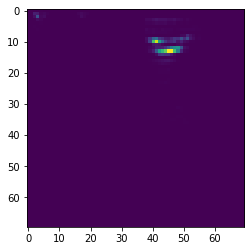

In [5]:
X_train_std = X_train_std[:, :70, :70]
X_test_std = X_test_std[:, :70, :70]
print(X_test_std.shape)
plt.imshow(X_test_std[1500,:,:].astype(np.float32))
plt.show()

(2000, 70, 70)
0
no


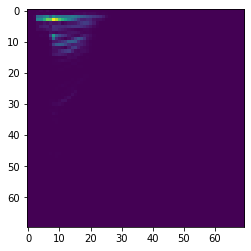

In [6]:
print(X_test_std.shape)
print(y_test_num[1])
print(label_names[y_test_num[1]])
plt.imshow(X_test_std[1,:,:].astype(np.float32))
plt.show()

In [7]:
X_train_std = np.reshape(X_train_std, (15000,4900))
X_test_std = np.reshape(X_test_std, (2000,4900))
print(X_train_std.shape)

(15000, 4900)


In [8]:
def standardize(input_data):
    sigma = np.std(input_data, axis=1)
    size = input_data.shape[0]
    sigma = sigma.reshape((size, 1))
    mean_val = np.mean(input_data, axis=1)
    mean_val = mean_val.reshape((size, 1))
    return (input_data-mean_val) / sigma

In [9]:
"""Convolutional Neural Network"""

'Convolutional Neural Network'

In [11]:
import tensorflow as tf

In [12]:
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

In [65]:
dropout_rate= 0.6
learning_rate = 0.002

In [66]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    #placeholders
    tf_x = tf.placeholder(dtype = tf.float32,
                         shape = (None, 4900),
                         name='tf_x')
    tf_x_image = tf.reshape(tf_x,
                            shape=[-1, 70, 70, 1],
                            name='tf_x_image')
    tf_y = tf.placeholder(dtype=tf.int32,
                         shape=(None),
                         name='tf_y')
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=n_classes,
                            name='tf_y_onehot')
    
    is_train = tf.placeholder(dtype=tf.bool, shape=(),
                                name='is_train')
    
    h1 = tf.layers.conv2d(tf_x_image,
                         kernel_size=(5,5),
                         filters=8,
                         activation=tf.sigmoid,
                         name='layer1')
    h1_pool = tf.layers.max_pooling2d(h1, pool_size=(2,2),
                                     strides=(2,2),
                                     name='layer1_pool')
    h2 = tf.layers.conv2d(h1_pool,
                         kernel_size=(5,5),
                         filters=16,
                         activation=tf.sigmoid,
                         name='layer2')
    h2_pool = tf.layers.max_pooling2d(h2, pool_size=(2,2),
                                     strides=(2,2),
                                     name='layer2_pool')
    
    input_shape = h2_pool.get_shape().as_list()
    n_input_units = np.prod(input_shape[1:])
    h2_pool_flat = tf.reshape(h2_pool,
                             shape=[-1,n_input_units],
                             name='layer2_pool_flat')
    h3 = tf.layers.dense(h2_pool_flat,
                         1024,
                         activation = tf.sigmoid,
                        name='layer3')
    h3_drop = tf.layers.dropout(h3,
                        rate = dropout_rate,
                        training=is_train,
                               name='layer3_drop')
    logits = tf.layers.dense(h3_drop, 10,
                        activation=None,
                        name='logits')
    
    predictions = {
        'probabilities' : tf.nn.softmax(logits,
                                       name='prob_softmax'),
        'labels' : tf.cast(tf.argmax(logits, axis=1),
                          tf.int32, name='predicted_labels')
    }
    
    cost = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf_y_onehot, logits = logits, name='cost')
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(cost, name='train_op')
    
    init_op = tf.global_variables_initializer()
    

 

W0826 18:26:01.711057  1128 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [54]:
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, :-1].astype(int)
        
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i : i+batch_size, :], y_copy[i : i+batch_size])

In [67]:
def create_batch_generator(X, y, batch_size=64,
                        shuffle=False, random_seed=None):
        idx = np.arange(y.shape[0])
        if shuffle:
            idx_shuffle = np.random.permutation(idx)
            X = X[idx_shuffle,:]
            y = y[idx_shuffle]

        for i in range(0, X.shape[0], batch_size):
            yield (X[i:i + batch_size, :], y[i:i + batch_size])

In [68]:
sess = tf.Session(graph=g)
sess.run(init_op)

In [69]:
for epoch in range(200):
    training_costs = []
    batch_generator = create_batch_generator(
                        X_train_std, y_train_num,
                        batch_size=500, shuffle=True)
    for batch_X, batch_y in batch_generator:
        feed={'tf_x:0': batch_X, 'tf_y:0': batch_y, 'is_train:0': True}
        batch_cost, _ = sess.run(['cost:0', 'train_op'], feed_dict=feed)
        training_costs.append(batch_cost)
    if (epoch+1) % 4 == 0:
        print('-- It:', epoch+1, np.mean(training_costs))
    else:
        print('-- It:', epoch+1, np.mean(training_costs), end='\t')

-- It: 1 0.46870604	-- It: 2 0.37229398	-- It: 3 0.35363436	-- It: 4 0.34071907
-- It: 5 0.333777	-- It: 6 0.33068493	-- It: 7 0.3289602	-- It: 8 0.32834864
-- It: 9 0.3271987	-- It: 10 0.3256637	-- It: 11 0.32198188	-- It: 12 0.31586727
-- It: 13 0.30903485	-- It: 14 0.30148426	-- It: 15 0.2938011	-- It: 16 0.28886446
-- It: 17 0.28514642	-- It: 18 0.28149122	-- It: 19 0.27826983	-- It: 20 0.27448228
-- It: 21 0.27184582	-- It: 22 0.26791722	-- It: 23 0.2641658	-- It: 24 0.2622054
-- It: 25 0.2581369	-- It: 26 0.25378695	-- It: 27 0.24964708	-- It: 28 0.2454217
-- It: 29 0.2416325	-- It: 30 0.23794219	-- It: 31 0.23484518	-- It: 32 0.23061948
-- It: 33 0.22793034	-- It: 34 0.22387633	-- It: 35 0.22133899	-- It: 36 0.21702084
-- It: 37 0.2157543	-- It: 38 0.21287794	-- It: 39 0.20990118	-- It: 40 0.20754863
-- It: 41 0.2065042	-- It: 42 0.20309797	-- It: 43 0.20009585	-- It: 44 0.19851042
-- It: 45 0.19524252	-- It: 46 0.19143705	-- It: 47 0.18523753	-- It: 48 0.18138346
-- It: 49 0.17

In [70]:
"""TRAINING SET"""
feed={'tf_x:0':X_train_std, 'is_train:0':False}
y_pred = sess.run(predictions['labels'], feed_dict=feed)
print('Dokładność dla podzbioru trenującego: %.2f%%' % (
            100*np.sum(y_pred == y_train_num)/y_train_num.shape[0]))
"""TEST SET"""
feed={'tf_x:0':X_test_std, 'is_train:0':False}
y_pred = sess.run(predictions['labels'], feed_dict=feed)
print('Dokładność dla podzbioru testującego: %.2f%%' % (
            100*np.sum(y_pred == y_test_num)/y_test_num.shape[0]))

Dokładność dla podzbioru trenującego: 97.63%
Dokładność dla podzbioru testującego: 82.05%


In [78]:
with g.as_default():
    saver = tf.train.Saver()
    save_path = saver.save(sess, "model_200.ckpt")
    